In [20]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.morphology import remove_small_objects


Use the function from the previous task to make the process easier

In [21]:
def roi_image(input_im, offset=10):

    if len(input_im.shape) == 3 and input_im.shape[2] == 3:
        im_gray = cv2.cvtColor(input_im, cv2.COLOR_BGR2GRAY)
    elif len(input_im.shape) == 2:
        # If the input image is already grayscale, no need to convert
        im_gray = input_im
    else:
        # Handle other cases (e.g., images with more than 3 channels)
        raise ValueError("Unsupported number of channels in input image")

    kernel = np.ones((50, 50), dtype="uint8")

    im_e = cv2.dilate(im_gray, kernel, iterations=1)
    im_closing = cv2.erode(im_e, kernel, iterations=1)

    th, output_im = cv2.threshold(im_closing, 160, 255, cv2.THRESH_BINARY)

    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    area_of_interest = None
    largest_area = 0

    for i in range(1, len(stats)):
        x, y, w, h, area = stats[i]
        if area > largest_area:
            largest_area = area
            area_of_interest = (x, y, w, h)

    x, y, w, h = area_of_interest

    # Adjust width and height to make a perfect square with an offset
    side_length = max(w, h) + 2 * offset
    x = max(0, x - offset)
    y = max(0, y - offset)

    roi = input_im[y:y+side_length, x:x+side_length]
    return roi

Function, which is supposed to perform the instance segmantation:
- It converts the image to gray scale;
- Use adaptive threshold for creating the binary mask and segment the plants;
- Take the counters of the objects;
- Remove the objects with counters under the specified area;
- Use connected components to take the instances 

In [22]:
def process_image(image, threshold_area=2500):
    """
    Process the input image by applying adaptive thresholding and filtering small contours.

    Parameters:
    - image: Input image (BGR format).
    - threshold_area: Minimum area for contours to be retained.
    - adaptive_method: Adaptive thresholding method.

    Returns:
    - Labeled image.
    """
    im_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    output_im = cv2.adaptiveThreshold(im_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 51, 8)

    # Find contours in the binary image
    contours, _ = cv2.findContours(output_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate through contours
    for contour in contours:
        area = cv2.contourArea(contour)
        
        # If the contour area is smaller than the threshold, ignore it
        if area < threshold_area:
            cv2.drawContours(output_im, [contour], 0, 0, -1)

    # Alternatively, you can use connected components to remove small objects
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    return labels

In [23]:
images_folder =  'task_3_images'

file_list = os.listdir(images_folder)

images = []

for filename in file_list:
    if filename.endswith('.png'):
        input_image_path = os.path.join(images_folder, filename)

        input_image = cv2.imread(input_image_path)

        images.append(input_image)

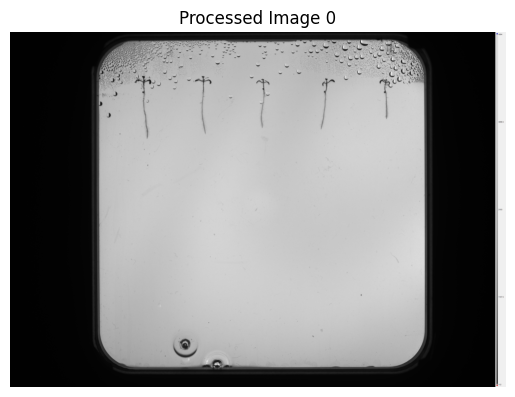

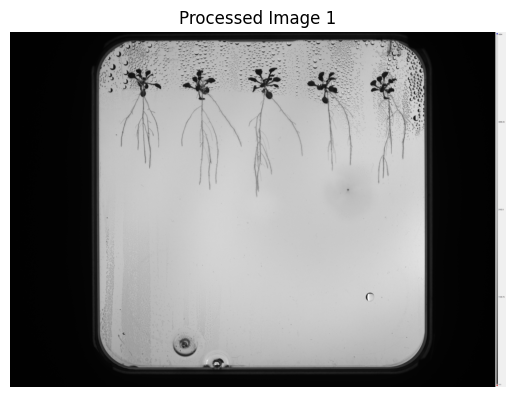

In [24]:
for idx, img in enumerate(images):
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f"Processed Image {idx}")
    plt.axis('off')  
    plt.show()

Test the code on two images:
- Use the function from task 2 to crop the images
- More cropping was done to remove noise from the bottom of the petri dish, which was hard to remove.

In [25]:
roi_images = []

for image in images:
    image = roi_image(image)
    image = image[200:2500, 170:2700]
    roi_images.append(image)

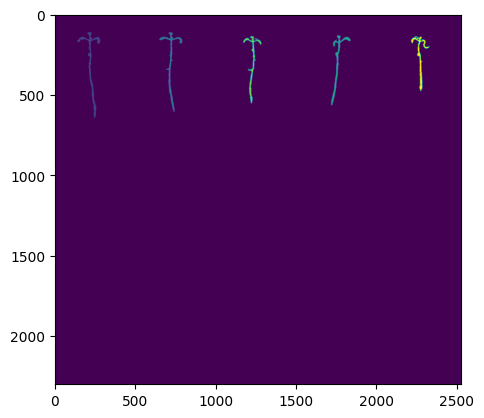

In [26]:
output = process_image(roi_images[0])
plt.imshow(output)

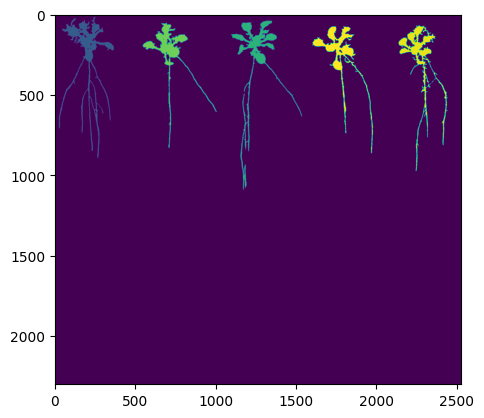

In [36]:
im = cv2.medianBlur(roi_images[1], 5)
th, output_im = cv2.threshold(im, 155, 255, cv2.THRESH_BINARY_INV)
output_im = cv2.cvtColor(output_im, cv2.COLOR_BGR2GRAY)

# Connected Components
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

# Removing small objects
min_size = 2000  # Adjust this value based on the minimum size you want to keep
labels_cleaned = remove_small_objects(labels, min_size=min_size)
plt.imshow(labels_cleaned)